In [2]:
%load_ext autoreload
%autoreload 2

import  src.init
import  emcee
import  corner
import  numpy               as np 
import  matplotlib.pyplot   as plt
from    math                import inf
from    pathlib             import Path
from    src.top_hat.montecarlo import *
from src.top_hat.plot       import TopHatPlotter

plt.style.use('./configurations/style.mplstyle') #? Custom style, makes plots easier to read

In [3]:
datafiles   = Path("datafiles")
N_WALKERS   = 20

# Overall Efficiency

In [4]:
# Model configuration
N_PARAMS    = 5
PARAM_NAMES = ["A_index", "L_L0", "L_mu_E", "sigma_E", "epsilon"]
U_MAX       = 1 - np.cos(np.deg2rad(25))
F_MAX       = 10
U_MAX       = F_MAX * U_MAX
print(f"U_MAX: {U_MAX}")
def log_prior(thetas):
    A_index, L_L0, L_mu_E, sigma_E, eps = thetas
    
    if not (1.5 < A_index < 12)          : return -inf
    if not (-2 < L_L0 < 6)              : return -inf
    if not (1 < L_mu_E < 6.5)           : return -inf
    if not (0 < sigma_E < 1.8)          : return -inf
    if not (1e-5 < eps < U_MAX * 0.999) : return -inf
    
    prior = 1 / U_MAX * np.log(U_MAX / eps)
    return np.log(prior)

def log_likelihood_default(thetas, params_in, distances, k_interpolator, n_events=10_000):
    """
    Simulate exactly n_years of GRB observations.
    """
    epsilon                 = thetas[-1]
    gbm_eff                 = 0.6
    
    # Calculate expected number of GRBs for n_years
    n_years                 = params_in.triggered_years 
    intrinsic_rate_per_year = epsilon * len(params_in.z_arr) * gbm_eff
    expected_total_events   = intrinsic_rate_per_year * n_years
    
    if expected_total_events < 10:
        return -inf, -inf, -inf, -inf, -inf

    results                     = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)
    
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])
    
    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf
    
    detected_events         = np.sum(trigger_mask)
    detection_efficiency    = detected_events / n_events

    #simulated_rate_per_year = detected_events / n_years
    #predicted_detections    = simulated_rate_per_year * params_in.triggered_years
    
    predicted_detections    = expected_total_events * detection_efficiency

    # Observed detections in the actual catalog
    observed_detections     = params_in.yearly_rate * params_in.triggered_years

    l1                      = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2                      = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3                      = poiss_log(k=observed_detections, mu=predicted_detections)
    l4                      = np.sum(trigger_mask) / n_events
    
    return l1 + l2 + l3, l1, l2, l3, l4

def initialize_walkers(n_walkers):
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),                 # A_index
        np.random.uniform(2, 4.0, n_walkers),               # L_L0
        np.random.uniform(2.0, 4.0, n_walkers),             # L_mu_E
        np.random.uniform(0.2, 1, n_walkers),               # sigma_E
        np.random.uniform(1e-4, 10**-3.5, n_walkers),       # epsilon
    ])

U_MAX: 0.9369221296335006


In [17]:
# Where to find the datafiles and save the outputs
output_dir_eps  = src.init.create_run_dir(f"Epsilon_Tests/test_default_proper_new_max_10k")
params = {
    "alpha"         : -0.67,    # 2/3 from synchrotron
    "beta_s"        : -2.59,    # Average value from GRBs
    "n"             : 2,        # Smoothly broken power law curvature
    "theta_c"       : 3.4,      # Ghirlanda half-angle of jet core (from GW170817)
    "theta_v_max"   : 10,       # Maximum viewing angle of the jet (in degrees)
    "z_model"      : 'fiducial_Hrad_A1.0'    #? Optional, model to use for redshift distribution
}
default_params, _, data_dict = src.init.initialize_simulation(datafiles, params=params) #? Catalogue data from fermi GBM

print(f"Total events in the catalogue: {len(default_params.pflux_data)}")

n_walkers       = 20
n_steps         = 200_000

k_interpolator  = create_k_interpolator()

log_likelihood_default_in = create_log_probability_function(
    log_prior_func          =   log_prior,
    log_likelihood_func     =   log_likelihood_default,
    params_in               =   default_params,
    k_interpolator          =   k_interpolator
)

filename    = output_dir_eps / "emcee.h5"
initial_pos, n_steps, backend = check_and_resume_mcmc(
    filename    =   filename, 
    n_steps     =   n_steps, 
    initialize_walkers_func   =   initialize_walkers, 
    n_walkers   =   n_walkers
)

sampler = run_mcmc(
    log_probability_func    =   log_likelihood_default_in,
    initial_walkers         =   initial_pos,
    n_iterations            =   n_steps,
    n_walkers               =   n_walkers,
    n_params                =   N_PARAMS,
    backend                 =   backend,
)

Loading existing directory  : Output_files/Epsilon_Tests/test_default_proper_new_max_10k
Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Total events in the catalogue: 268
Already completed this run


0it [00:00, ?it/s]


In [18]:
backend     = emcee.backends.HDFBackend(output_dir_eps / "emcee.h5")

In [19]:
# Cell: Plotting results
# After running MCMC
output_dir_eps  = src.init.create_run_dir(f"Epsilon_Tests/test_default_proper_new_max_10k")

plotter         = TopHatPlotter(
    backend     =   backend,
    output_dir  =   output_dir_eps,
    model_type  =   "epsilon",  # or "flat_theta", "lognormal_theta"
    burn_in     =   1000,
    thin        =   15
)

# Generate all plots
distances = compute_luminosity_distance(default_params.z_arr)
summary = plotter.generate_all_plots(
    mc_func         =   simplified_montecarlo,
    params_in       =   default_params,
    distances       =   distances,
    k_interpolator  =   k_interpolator
)

print(summary)  # Print LaTeX table

Loading existing directory  : Output_files/Epsilon_Tests/test_default_proper_new_max_10k
Generating corner plot...
(339560, 5)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/Epsilon_Tests/test_default_proper_new_max_10k
\begin{tabular}{lc}
\hline
Parameter & Value \\
\hline
$k$ & $3.883_{-1.274}^{+1.555}$ \\
$\log_{10}(L_0/10^{49}\mathrm{erg/s})$ & $2.885_{-0.496}^{+0.518}$ \\
$\log_{10}(\mu_E/\mathrm{keV})$ & $3.396_{-0.147}^{+0.277}$ \\
$\sigma_E$ & $0.383_{-0.075}^{+0.125}$ \\
$\log(\epsilon)$ & $-2.409_{-0.573}^{+0.507}$ \\
\hline
\end{tabular}


Mean equivalent fj for Θc = 3.4°: 0.530526358339486
Mean equivalent fj for Θc = 3.4° not limited: 2.213581226184768


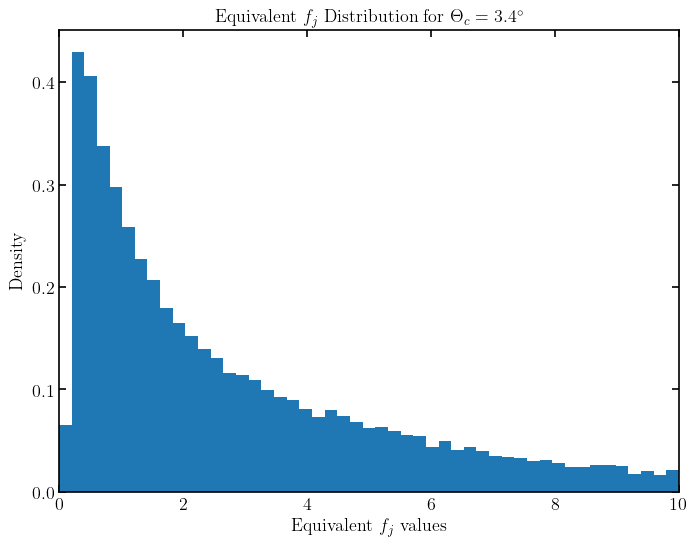

Mean theta_c needed for fj = 0.72: 5.963383240122873 degrees


In [20]:
# get epsilon 
epsilon_samples = backend.get_chain(discard=1000, thin=20, flat=True)[:,-1]

theta_c_test    = np.deg2rad(3.4)
factor          = (1 - np.cos(theta_c_test)) 
equivalent_fj   = epsilon_samples / factor
print(f"Mean equivalent fj for Θc = 3.4°: {np.median(equivalent_fj[equivalent_fj<1])}")
print(f"Mean equivalent fj for Θc = 3.4° not limited: {np.median(equivalent_fj)}")
bins = np.linspace(0, 10, 50)
plt.hist(equivalent_fj, bins=bins, density=True)
plt.xlim(0, 10)
plt.xlabel("Equivalent $f_j$ values")
plt.ylabel("Density")
plt.title("Equivalent $f_j$ Distribution for $\Theta_c = 3.4^\circ$")
plt.show()

# fj = 0.72, what is theta_c needed to obtain this median 
fj_target = 0.72
theta_c_needed = np.arccos(1 - epsilon_samples / fj_target)
print(f"Mean theta_c needed for fj = {fj_target}: {np.rad2deg(np.median(theta_c_needed[theta_c_needed < np.pi/2]))} degrees")

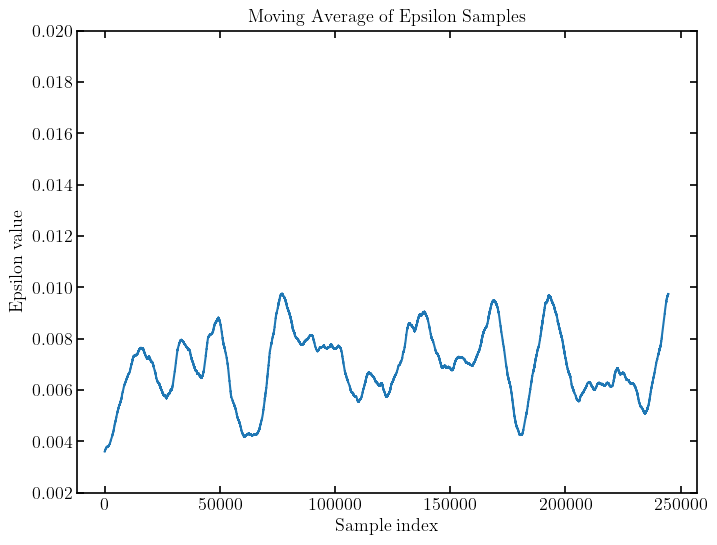

In [21]:
# moving average of epsilon 
N = 10_000
mov_epsilon = np.convolve(epsilon_samples, np.ones(N)/N, mode='valid')
plt.plot(mov_epsilon)
# plot raw epsilon samples
plt.ylim(0.002, 0.02)
plt.xlabel("Sample index")
plt.ylabel("Epsilon value")
plt.title("Moving Average of Epsilon Samples")
plt.show()

# Flat Theta

In [7]:
# Cell: Model-specific definitions

from src.top_hat.montecarlo import *

N_PARAMS    = 6
PARAM_NAMES = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_max", "fj"]

def log_prior_ft(thetas, max_fj = 10):
    A_index, L_L0, L_mu_E, sigma_E, theta_c_max, fj = thetas
    
    if not (1.5 < A_index < 12): return -inf
    if not (-2 < L_L0 < 7): return -inf
    if not (0.1 < L_mu_E < 7): return -inf
    if not (0 < sigma_E < 2.5): return -inf
    if not (1 < theta_c_max < 25): return -inf
    if not (0 < fj < max_fj): return -inf
    
    return 0.0

def log_likelihood_flat_theta(thetas, params_in, distances, k_interpolator, n_events=10_000):
    theta_c_max, fj             = thetas[4], thetas[5]
    gbm_eff                     = 0.6
    geometric_efficiency        = calculate_geometric_efficiency_flat(theta_c_max)
    triggered_years             = params_in.triggered_years
    epsilon                     = geometric_efficiency * fj
    n_years                     = triggered_years
    intrinsic_rate_per_year     = epsilon * len(params_in.z_arr) * gbm_eff
    expected_events             = intrinsic_rate_per_year * n_years
    #n_events                    = int(expected_events)
    
    results                     = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)
    
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])
    
    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf
    
    
    triggered_events        = np.sum(trigger_mask)
    physics_efficiency      = triggered_events  / n_events

    #simulated_rate_per_year = triggered_events / n_years
    #predicted_detections    = simulated_rate_per_year * params_in.triggered_years
    
    predicted_detections    = expected_events * physics_efficiency
    observed_detections     = params_in.yearly_rate * params_in.triggered_years

    l1 = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2 = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3 = poiss_log(k=observed_detections, mu=predicted_detections)

    return l1 + l2 + l3, l1, l2, l3, physics_efficiency

def initialize_walkers_ft(n_walkers):
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),
        np.random.uniform(2, 4.0, n_walkers),
        np.random.uniform(2.0, 4.0, n_walkers),
        np.random.uniform(0.2, 1, n_walkers),
        np.random.uniform(1, 10, n_walkers),    # theta_c_max
        np.random.uniform(0.5, 4, n_walkers),   # fj
    ])

In [23]:
# Where to find the datafiles and save the outputs
output_dir_ft  = src.init.create_run_dir(f"Paper_Results/Flat_Theta/fiducial")

default_params, _, data_dict = src.init.initialize_simulation(datafiles, params=params) #? Catalogue data from fermi GBM

print(f"Total events in the catalogue: {len(default_params.pflux_data)}")

n_walkers       = 20
n_steps         = 60_000

k_interpolator  = create_k_interpolator()
initial_walkers = initialize_walkers_ft(n_walkers)

log_likelihood_default_in_ft = create_log_probability_function(
    log_prior_func          =   log_prior_ft,
    log_likelihood_func     =   log_likelihood_flat_theta,
    params_in               =   default_params,
    k_interpolator          =   k_interpolator
)

filename    = output_dir_ft / "emcee.h5"
initial_pos, n_steps, backend = check_and_resume_mcmc(
    filename                    =   filename, 
    n_steps                     =   n_steps, 
    initialize_walkers_func     =   initialize_walkers_ft, 
    n_walkers                   =   n_walkers
)

sampler = run_mcmc(
    log_probability_func    =   log_likelihood_default_in_ft,
    initial_walkers         =   initial_pos,
    n_iterations            =   n_steps,
    n_walkers               =   n_walkers,
    n_params                =   N_PARAMS,
    backend                 =   backend,
)

Loading existing directory  : Output_files/Paper_Results/Flat_Theta/fiducial
Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Total events in the catalogue: 268
Already completed this run


0it [00:00, ?it/s]


In [24]:
# Make sure we're using the backend from the flat_theta run
backend_ft  = emcee.backends.HDFBackend(output_dir_ft / "emcee.h5")

plotter_flat_theta = TopHatPlotter(
    backend     =   backend_ft,  # Use explicit backend variable
    output_dir  =   output_dir_ft,
    model_type  =   "flat_theta",
    burn_in     =   1000,
    thin        =   15
)   

# Generate all plots
distances = compute_luminosity_distance(default_params.z_arr)
summary = plotter_flat_theta.generate_all_plots(
    mc_func=simplified_montecarlo,
    params_in=default_params,
    distances=distances,
    k_interpolator=k_interpolator,
    geometric_eff_func=calculate_geometric_efficiency_flat
)
print(summary)

Generating corner plot...
(78660, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/Paper_Results/Flat_Theta/fiducial
\begin{tabular}{lc}
\hline
Parameter & Value \\
\hline
$k$ & $6.127_{-2.836}^{+3.757}$ \\
$\log_{10}(L_0)$ & $3.153_{-0.480}^{+0.429}$ \\
$\log_{10}(\mu_E)$ & $3.425_{-0.171}^{+0.373}$ \\
$\sigma_E$ & $0.394_{-0.085}^{+0.155}$ \\
$\theta_{c,\max}$ (deg) & $4.197_{-2.365}^{+5.036}$ \\
$f_j$ & $2.827_{-2.156}^{+3.876}$ \\
\hline
\end{tabular}


Mean fj: 2.8314288667354264


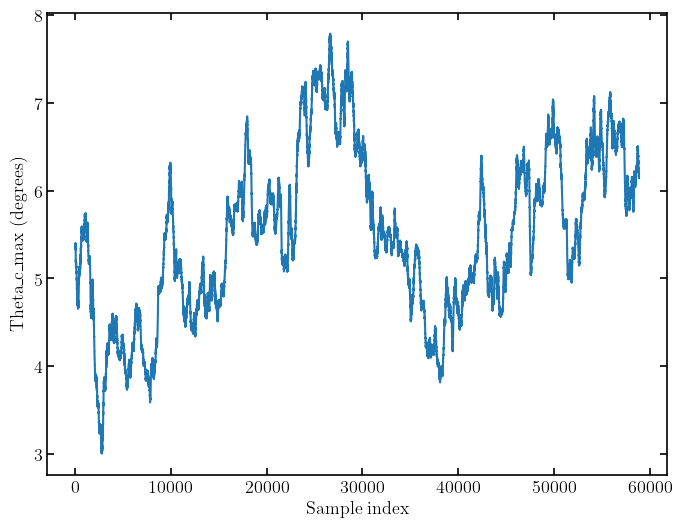

In [25]:
fj = backend_ft.get_chain(discard=1000, thin=20, flat=True)[:,-1]
print(f"Mean fj: {np.median(fj)}")

theta_c_max = backend_ft.get_chain(discard=1000, thin=20, flat=True)[:,-2]

running_mean_theta_c = np.convolve(theta_c_max, np.ones(100)/100, mode='valid')
plt.plot(running_mean_theta_c)
plt.xlabel("Sample index")
plt.ylabel("Theta_c_max (degrees)")
plt.show()

# Log-Normal

In [26]:
# Cell: Model-specific definitions

from src.top_hat.montecarlo import *

N_PARAMS        = 6
PARAM_NAMES     = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_med_10", "fj"]

def log_prior_log_normal(thetas, max_fj=10):
    A_index, L_L0, L_mu_E, sigma_E, theta_c_med_10, fj = thetas

    if not (1.5 < A_index < 12): return -inf
    if not (-2 < L_L0 < 7): return -inf
    if not (0.1 < L_mu_E < 7): return -inf
    if not (0 < sigma_E < 2.5): return -inf
    if not (np.log10(1) < theta_c_med_10 < np.log10(25)): return -inf
    if not (0 < fj < max_fj): return -inf
    
    return 0.0

geom_eff_interp = create_geometric_efficiency_lognormal_interpolator(sigma_theta_c=0.5)
def log_likelihood_log_normal(thetas, params_in, distances, k_interpolator, n_events=10_000):
    theta_c_med_10, fj          = thetas[4], thetas[5]
    
    gbm_eff                     = 0.6
    geometric_efficiency        = geom_eff_interp(theta_c_med_10)
    triggered_years             = params_in.triggered_years
    epsilon                     = geometric_efficiency * fj

    factor                      = 1 # Simulate less as the effieicny is already making this hella slow
    n_years                     = triggered_years / factor
    intrinsic_rate_per_year     = epsilon * len(params_in.z_arr) * gbm_eff
    expected_events             = intrinsic_rate_per_year * n_years
    #n_events                    = int(expected_events)
    
    #if n_events < 50/factor:  # We have 300 events in the data, so even with perfect detection we need at least this many
    #    return -inf, -inf, -inf, -inf, -inf
    
    results                     = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)
    
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])
    
    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf
    
    triggered_events        = np.sum(trigger_mask)
    physics_efficiency      = triggered_events  / n_events

    #simulated_rate_per_year = triggered_events / n_years
    #predicted_detections    = simulated_rate_per_year * params_in.triggered_years
    
    predicted_detections    = expected_events * physics_efficiency
    observed_detections     = params_in.yearly_rate * params_in.triggered_years
    
    l1 = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2 = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3 = poiss_log(k=observed_detections, mu=predicted_detections)
        
    return l1 + l2 + l3, l1, l2, l3, physics_efficiency

# log_likelihood similar to flat case but uses calculate_geometric_efficiency_lognormal

def initialize_walkers_log_normal(n_walkers):
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),
        np.random.uniform(2, 4.0, n_walkers),
        np.random.uniform(2.0, 4.0, n_walkers),
        np.random.uniform(0.2, 1, n_walkers),
        np.random.uniform(np.log10(5), np.log10(10), n_walkers),  
        np.random.uniform(0.5, 1, n_walkers),
    ])

In [27]:
output_dir_lm                       = src.init.create_run_dir(f"Paper_Results/Lognormal_Theta/fiducial")

Loading existing directory  : Output_files/Paper_Results/Lognormal_Theta/fiducial


In [28]:
# Where to find the datafiles and save the outputs

default_params, _, data_dict        = src.init.initialize_simulation(datafiles, params=params) #? Catalogue data from fermi GBM

print(f"Total events in the catalogue: {len(default_params.pflux_data)}")

n_walkers       = 20
n_steps         = 90_000

k_interpolator  = create_k_interpolator()

log_likelihood_default_in_log_normal = create_log_probability_function(
    log_prior_func          =   log_prior_log_normal,
    log_likelihood_func     =   log_likelihood_log_normal,
    params_in               =   default_params,
    k_interpolator          =   k_interpolator
)

initial_pos, n_steps, backend = check_and_resume_mcmc(
    filename                    =    output_dir_lm / "emcee.h5", 
    n_steps                     =   n_steps, 
    initialize_walkers_func     =   initialize_walkers_log_normal, 
    n_walkers                   =   n_walkers
)

sampler = run_mcmc(
    log_probability_func    =   log_likelihood_default_in_log_normal,
    initial_walkers         =   initial_pos,
    n_iterations            =   n_steps,
    n_walkers               =   n_walkers,
    n_params                =   N_PARAMS,
    backend                 =   backend,
)

Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Total events in the catalogue: 268
Already completed this run


0it [00:00, ?it/s]


In [29]:
# plot
backend_ln = emcee.backends.HDFBackend(output_dir_lm / "emcee.h5")

plotter_log_normal = TopHatPlotter(
    backend     =   backend_ln,
    output_dir  =   output_dir_lm,
    model_type  =   "lognormal_theta",
    burn_in     =   3_000,
    thin        =   15
)

# Generate all plots
distances = compute_luminosity_distance(default_params.z_arr)
summary = plotter_log_normal.generate_all_plots(
    mc_func=simplified_montecarlo,
    params_in=default_params,
    distances=distances,
    k_interpolator=k_interpolator,
    geometric_eff_func=geom_eff_interp
)

print(summary)  # Print LaTeX table

Generating corner plot...
(116000, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/Paper_Results/Lognormal_Theta/fiducial
\begin{tabular}{lc}
\hline
Parameter & Value \\
\hline
$k$ & $6.483_{-3.101}^{+3.772}$ \\
$\log_{10}(L_0)$ & $2.947_{-0.484}^{+0.517}$ \\
$\log_{10}(\mu_E)$ & $3.472_{-0.207}^{+0.646}$ \\
$\sigma_E$ & $0.420_{-0.100}^{+0.231}$ \\
$\log_{10}(\theta_{c,\mathrm{med}})$ & $0.259_{-0.200}^{+0.311}$ \\
$f_j$ & $0.650_{-0.529}^{+1.825}$ \\
\hline
\end{tabular}


In [30]:
theta_c_med_10_samples = backend_ln.get_chain(discard=1000, thin=20, flat=True)[:,-2]
print(f"Mean theta_c: {(10**np.median(theta_c_med_10_samples))} degrees")

Mean theta_c: 1.8277149663694712 degrees


In [31]:
1/0

ZeroDivisionError: division by zero

# Multiple Populations

In [8]:
from multiprocessing import Pool
from pathlib import Path
import src.init
from src.spectral_models import DEFAULT_SPECTRAL_PARAMS
population_folder = Path("datafiles") / "populations" / "samples"
#with glob find all the samples_*.dat files
samples         = list(population_folder.glob('samples_*.dat'))
samp_names      = [samp.name.split('samples_')[1].split('_BNSs')[0] for samp in samples]
print(f"Found {len(samples)} samples: {samp_names}")
total_num_samp  = len(samp_names)
datafiles       = Path("datafiles")

Found 64 samples: ['fiducial_delayed_A0.5', 'fiducial_delayed_A1.0', 'fiducial_delayed_A3.0', 'fiducial_delayed_A5.0', 'fiducial_fmtbse_A0.5', 'fiducial_fmtbse_A1.0', 'fiducial_fmtbse_A3.0', 'fiducial_fmtbse_A5.0', 'fiducial_HGoptimistic_A0.5', 'fiducial_HGoptimistic_A1.0', 'fiducial_HGoptimistic_A3.0', 'fiducial_HGoptimistic_A5.0', 'fiducial_Hrad_5M_A0.5', 'fiducial_Hrad_5M_A1.0', 'fiducial_Hrad_5M_A3.0', 'fiducial_Hrad_5M_A5.0', 'fiducial_Hrad_A0.5', 'fiducial_Hrad_A1.0', 'fiducial_Hrad_A3.0', 'fiducial_Hrad_A5.0', 'fiducial_kick150_A0.5', 'fiducial_kick150_A1.0', 'fiducial_kick150_A3.0', 'fiducial_kick150_A5.0', 'fiducial_kick265_A0.5', 'fiducial_kick265_A1.0', 'fiducial_kick265_A3.0', 'fiducial_kick265_A5.0', 'fiducial_klencki_A0.5', 'fiducial_klencki_A1.0', 'fiducial_klencki_A3.0', 'fiducial_klencki_A5.0', 'fiducial_l01_A0.5', 'fiducial_l01_A1.0', 'fiducial_l01_A3.0', 'fiducial_l01_A5.0', 'fiducial_notides_A0.5', 'fiducial_notides_A1.0', 'fiducial_notides_A3.0', 'fiducial_notides_

In [10]:
n_steps = 40_000  # Set to 2k as requested
n_walkers = 20
for z_test in samp_names:
    print(f"Processing population: {z_test} ({samp_names.index(z_test)+1}/{total_num_samp})")
    
    # --- Common Setup for this population ---
    # We only need to specify the z_model, other params use defaults inside initialize_simulation

    params_pop = DEFAULT_SPECTRAL_PARAMS.copy()
    params_pop["z_model"] = z_test

    # Initialize simulation with specific population
    current_params, _, _ = src.init.initialize_simulation(datafiles, params_pop)
    
    # Pre-compute distances and interpolator
    #distances       = compute_luminosity_distance(current_params.z_arr) # Done within create_log_probability_function now
    k_interpolator  = create_k_interpolator()

    # ==========================================
    # Model 1: Epsilon (Normal) - 5 Parameters
    # ==========================================
    # print(f"  >> Running Epsilon (Normal) model for {z_test}...")
    # output_dir_eps = src.init.create_run_dir(f"ProductionPop_Epsilon_10k/{z_test}", use_timestamp=False)
    # filename_eps = output_dir_eps / "emcee.h5"
    
    # # Create log prob function for Epsilon
    # log_prob_eps = create_log_probability_function(
    #     log_prior_func      =   log_prior,
    #     log_likelihood_func =   log_likelihood_default,
    #     params_in           =   current_params,
    #     k_interpolator      =   k_interpolator
    # )
    
    # # Check resume status
    # initial_pos_eps, steps_todo_eps, backend_eps = check_and_resume_mcmc(
    #     filename=filename_eps,
    #     n_steps=n_steps,
    #     initialize_walkers_func=initialize_walkers,
    #     n_walkers=n_walkers
    # )
    
    # # Run if needed
    # if steps_todo_eps > 0:
    #     run_mcmc(
    #         log_probability_func=log_prob_eps,
    #         initial_walkers=initial_pos_eps,
    #         n_iterations=steps_todo_eps,
    #         n_walkers=n_walkers,
    #         n_params=5,
    #         backend=backend_eps,
    #     )
    # else:
    #     print("     Epsilon model already completed.")

    # ==========================================
    # Model 2: Flat Theta - 6 Parameters
    # ==========================================
    print(f"  >> Running Flat Theta model for {z_test}...")
    output_dir_flat = src.init.create_run_dir(f"ProductionPop_Flat_10k_new_new/{z_test}", use_timestamp=False)
    filename_flat = output_dir_flat / "emcee.h5"
    

    # log prior with max_fj = 20
    log_prior_ft_in = lambda thetas: log_prior_ft(thetas, max_fj=20)
    # Create log prob function for Flat Theta
    log_prob_flat = create_log_probability_function(
        log_prior_func=log_prior_ft_in,
        log_likelihood_func=log_likelihood_flat_theta,
        params_in=current_params,
        k_interpolator=k_interpolator
    )
    
    # Check resume status
    initial_pos_flat, steps_todo_flat, backend_flat = check_and_resume_mcmc(
        filename=filename_flat,
        n_steps=n_steps,
        initialize_walkers_func=initialize_walkers_ft,
        n_walkers=n_walkers
    )
    
    # Run if needed
    if steps_todo_flat > 0:
        run_mcmc(
            log_probability_func=log_prob_flat,
            initial_walkers=initial_pos_flat,
            n_iterations=steps_todo_flat,
            n_walkers=n_walkers,
            n_params=6,
            backend=backend_flat,
        )
    else:
        print("     Flat Theta model already completed.")

    
    # =================================================
    # Model 3: Log normal 
    # ================================================
    # print(f"  >> Running log normal model for {z_test}...")
    # output_dir_ln = src.init.create_run_dir(f"ProductionPop_LogNorm_10k_new_new/{z_test}", use_timestamp=False)
    # filename_ln = output_dir_ln / "emcee.h5"
    
    # # Create log prob function for Flat Theta
    # log_prob_ln = create_log_probability_function(
    #     log_prior_func      =   log_prior_log_normal,
    #     log_likelihood_func =   log_likelihood_log_normal,
    #     params_in           =   current_params,
    #     k_interpolator      =   k_interpolator
    # )
    
    # # Check resume status
    # initial_pos_ln, steps_todo_ln, backend_ln = check_and_resume_mcmc(
    #     filename    =filename_ln,
    #     n_steps     =n_steps,
    #     initialize_walkers_func=initialize_walkers_log_normal,
    #     n_walkers   =n_walkers
    # )
    
    # # Run if needed
    # if steps_todo_ln > 0:
    #     run_mcmc(
    #         log_probability_func    =       log_prob_ln,
    #         initial_walkers         =       initial_pos_ln,
    #         n_iterations=   steps_todo_ln,
    #         n_walkers   =   n_walkers,
    #         n_params    =   6,
    #         backend     =   backend_ln,
    #     )
    # else:
    #     print("     Log Normal model already completed.")



Processing population: fiducial_delayed_A0.5 (1/64)
Using redshift model: samples_fiducial_delayed_A0.5_BNSs_0.dat with 60187 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_delayed_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_delayed_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:27<00:00, 15.94it/s]


Processing population: fiducial_delayed_A1.0 (2/64)
Using redshift model: samples_fiducial_delayed_A1.0_BNSs_0.dat with 342071 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_delayed_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_delayed_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [11:01<00:00, 15.12it/s]


Processing population: fiducial_delayed_A3.0 (3/64)
Using redshift model: samples_fiducial_delayed_A3.0_BNSs_0.dat with 358417 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_delayed_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_delayed_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:38<00:00, 15.67it/s]


Processing population: fiducial_delayed_A5.0 (4/64)
Using redshift model: samples_fiducial_delayed_A5.0_BNSs_0.dat with 136203 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_delayed_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_delayed_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:36<00:00, 15.71it/s]


Processing population: fiducial_fmtbse_A0.5 (5/64)
Using redshift model: samples_fiducial_fmtbse_A0.5_BNSs_0.dat with 33064 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_fmtbse_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_fmtbse_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:45<00:00, 15.49it/s]


Processing population: fiducial_fmtbse_A1.0 (6/64)
Using redshift model: samples_fiducial_fmtbse_A1.0_BNSs_0.dat with 233115 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_fmtbse_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_fmtbse_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:25<00:00, 15.99it/s]


Processing population: fiducial_fmtbse_A3.0 (7/64)
Using redshift model: samples_fiducial_fmtbse_A3.0_BNSs_0.dat with 283535 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_fmtbse_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_fmtbse_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:29<00:00, 15.88it/s]


Processing population: fiducial_fmtbse_A5.0 (8/64)
Using redshift model: samples_fiducial_fmtbse_A5.0_BNSs_0.dat with 95180 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_fmtbse_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_fmtbse_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [11:13<00:00, 14.85it/s]


Processing population: fiducial_HGoptimistic_A0.5 (9/64)
Using redshift model: samples_fiducial_HGoptimistic_A0.5_BNSs_0.dat with 7636 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_HGoptimistic_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_HGoptimistic_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:56<00:00, 15.24it/s]


Processing population: fiducial_HGoptimistic_A1.0 (10/64)
Using redshift model: samples_fiducial_HGoptimistic_A1.0_BNSs_0.dat with 57844 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_HGoptimistic_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_HGoptimistic_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:43<00:00, 15.53it/s]


Processing population: fiducial_HGoptimistic_A3.0 (11/64)
Using redshift model: samples_fiducial_HGoptimistic_A3.0_BNSs_0.dat with 361335 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_HGoptimistic_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_HGoptimistic_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:42<00:00, 15.56it/s]


Processing population: fiducial_HGoptimistic_A5.0 (12/64)
Using redshift model: samples_fiducial_HGoptimistic_A5.0_BNSs_0.dat with 812489 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_HGoptimistic_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_HGoptimistic_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:38<00:00, 15.66it/s]


Processing population: fiducial_Hrad_5M_A0.5 (13/64)
Using redshift model: samples_fiducial_Hrad_5M_A0.5_BNSs_0.dat with 63473 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_Hrad_5M_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_Hrad_5M_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:32<00:00, 15.81it/s]


Processing population: fiducial_Hrad_5M_A1.0 (14/64)
Using redshift model: samples_fiducial_Hrad_5M_A1.0_BNSs_0.dat with 359531 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_Hrad_5M_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_Hrad_5M_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:57<00:00, 15.20it/s]


Processing population: fiducial_Hrad_5M_A3.0 (15/64)
Using redshift model: samples_fiducial_Hrad_5M_A3.0_BNSs_0.dat with 370949 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_Hrad_5M_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_Hrad_5M_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:41<00:00, 15.60it/s]


Processing population: fiducial_Hrad_5M_A5.0 (16/64)
Using redshift model: samples_fiducial_Hrad_5M_A5.0_BNSs_0.dat with 145179 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_Hrad_5M_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_Hrad_5M_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:33<00:00, 15.79it/s]


Processing population: fiducial_Hrad_A0.5 (17/64)
Using redshift model: samples_fiducial_Hrad_A0.5_BNSs_0.dat with 62278 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_Hrad_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_Hrad_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:35<00:00, 15.74it/s]


Processing population: fiducial_Hrad_A1.0 (18/64)
Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_Hrad_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_Hrad_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:30<00:00, 15.87it/s]


Processing population: fiducial_Hrad_A3.0 (19/64)
Using redshift model: samples_fiducial_Hrad_A3.0_BNSs_0.dat with 368417 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_Hrad_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_Hrad_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:31<00:00, 15.83it/s]


Processing population: fiducial_Hrad_A5.0 (20/64)
Using redshift model: samples_fiducial_Hrad_A5.0_BNSs_0.dat with 139399 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_Hrad_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_Hrad_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:19<00:00, 16.13it/s]


Processing population: fiducial_kick150_A0.5 (21/64)
Using redshift model: samples_fiducial_kick150_A0.5_BNSs_0.dat with 52912 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_kick150_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_kick150_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:12<00:00, 16.32it/s]


Processing population: fiducial_kick150_A1.0 (22/64)
Using redshift model: samples_fiducial_kick150_A1.0_BNSs_0.dat with 171232 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_kick150_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_kick150_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:10<00:00, 16.37it/s]


Processing population: fiducial_kick150_A3.0 (23/64)
Using redshift model: samples_fiducial_kick150_A3.0_BNSs_0.dat with 152077 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_kick150_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_kick150_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:23<00:00, 16.05it/s]


Processing population: fiducial_kick150_A5.0 (24/64)
Using redshift model: samples_fiducial_kick150_A5.0_BNSs_0.dat with 76755 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_kick150_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_kick150_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:40<00:00, 15.61it/s]


Processing population: fiducial_kick265_A0.5 (25/64)
Using redshift model: samples_fiducial_kick265_A0.5_BNSs_0.dat with 22928 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_kick265_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_kick265_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [14:58<00:00, 11.13it/s]


Processing population: fiducial_kick265_A1.0 (26/64)
Using redshift model: samples_fiducial_kick265_A1.0_BNSs_0.dat with 87725 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_kick265_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_kick265_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [14:33<00:00, 11.45it/s]


Processing population: fiducial_kick265_A3.0 (27/64)
Using redshift model: samples_fiducial_kick265_A3.0_BNSs_0.dat with 61461 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_kick265_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_kick265_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:41<00:00, 15.59it/s]


Processing population: fiducial_kick265_A5.0 (28/64)
Using redshift model: samples_fiducial_kick265_A5.0_BNSs_0.dat with 32517 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_kick265_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_kick265_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:36<00:00, 15.70it/s]


Processing population: fiducial_klencki_A0.5 (29/64)
Using redshift model: samples_fiducial_klencki_A0.5_BNSs_0.dat with 297 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_klencki_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_klencki_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [11:06<00:00, 15.00it/s]


Processing population: fiducial_klencki_A1.0 (30/64)
Using redshift model: samples_fiducial_klencki_A1.0_BNSs_0.dat with 13202 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_klencki_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_klencki_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:07<00:00, 16.47it/s]


Processing population: fiducial_klencki_A3.0 (31/64)
Using redshift model: samples_fiducial_klencki_A3.0_BNSs_0.dat with 213423 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_klencki_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_klencki_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:16<00:00, 16.21it/s]


Processing population: fiducial_klencki_A5.0 (32/64)
Using redshift model: samples_fiducial_klencki_A5.0_BNSs_0.dat with 299205 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_klencki_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_klencki_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:28<00:00, 15.92it/s]


Processing population: fiducial_l01_A0.5 (33/64)
Using redshift model: samples_fiducial_l01_A0.5_BNSs_0.dat with 24266 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_l01_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_l01_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:32<00:00, 15.81it/s]


Processing population: fiducial_l01_A1.0 (34/64)
Using redshift model: samples_fiducial_l01_A1.0_BNSs_0.dat with 97613 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_l01_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_l01_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [12:46<00:00, 13.04it/s]


Processing population: fiducial_l01_A3.0 (35/64)
Using redshift model: samples_fiducial_l01_A3.0_BNSs_0.dat with 264224 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_l01_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_l01_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [15:39<00:00, 10.64it/s]


Processing population: fiducial_l01_A5.0 (36/64)
Using redshift model: samples_fiducial_l01_A5.0_BNSs_0.dat with 413738 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_l01_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_l01_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [14:03<00:00, 11.85it/s]


Processing population: fiducial_notides_A0.5 (37/64)
Using redshift model: samples_fiducial_notides_A0.5_BNSs_0.dat with 54157 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_notides_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_notides_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [15:22<00:00, 10.84it/s]


Processing population: fiducial_notides_A1.0 (38/64)
Using redshift model: samples_fiducial_notides_A1.0_BNSs_0.dat with 295211 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_notides_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_notides_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [14:32<00:00, 11.46it/s]


Processing population: fiducial_notides_A3.0 (39/64)
Using redshift model: samples_fiducial_notides_A3.0_BNSs_0.dat with 295830 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_notides_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_notides_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [15:35<00:00, 10.68it/s]


Processing population: fiducial_notides_A5.0 (40/64)
Using redshift model: samples_fiducial_notides_A5.0_BNSs_0.dat with 114874 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_notides_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_notides_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [12:07<00:00, 13.74it/s]


Processing population: fiducial_notides_pericirc_A0.5 (41/64)
Using redshift model: samples_fiducial_notides_pericirc_A0.5_BNSs_0.dat with 138037 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_notides_pericirc_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_notides_pericirc_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [11:33<00:00, 14.42it/s]


Processing population: fiducial_notides_pericirc_A1.0 (42/64)
Using redshift model: samples_fiducial_notides_pericirc_A1.0_BNSs_0.dat with 705045 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_notides_pericirc_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_notides_pericirc_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [11:49<00:00, 14.09it/s]


Processing population: fiducial_notides_pericirc_A3.0 (43/64)
Using redshift model: samples_fiducial_notides_pericirc_A3.0_BNSs_0.dat with 611468 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_notides_pericirc_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_notides_pericirc_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [12:07<00:00, 13.74it/s]


Processing population: fiducial_notides_pericirc_A5.0 (44/64)
Using redshift model: samples_fiducial_notides_pericirc_A5.0_BNSs_0.dat with 241080 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_notides_pericirc_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_notides_pericirc_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:59<00:00, 15.15it/s]


Processing population: fiducial_pisnfarmer19_A0.5 (45/64)
Using redshift model: samples_fiducial_pisnfarmer19_A0.5_BNSs_0.dat with 62278 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_pisnfarmer19_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_pisnfarmer19_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:12<00:00, 16.32it/s]


Processing population: fiducial_pisnfarmer19_A1.0 (46/64)
Using redshift model: samples_fiducial_pisnfarmer19_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_pisnfarmer19_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_pisnfarmer19_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:42<00:00, 15.58it/s]


Processing population: fiducial_pisnfarmer19_A3.0 (47/64)
Using redshift model: samples_fiducial_pisnfarmer19_A3.0_BNSs_0.dat with 368417 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_pisnfarmer19_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_pisnfarmer19_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:27<00:00, 15.94it/s]


Processing population: fiducial_pisnfarmer19_A5.0 (48/64)
Using redshift model: samples_fiducial_pisnfarmer19_A5.0_BNSs_0.dat with 139399 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_pisnfarmer19_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_pisnfarmer19_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:27<00:00, 15.94it/s]


Processing population: fiducial_qcbse_A0.5 (49/64)
Using redshift model: samples_fiducial_qcbse_A0.5_BNSs_0.dat with 7215 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_qcbse_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_qcbse_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:30<00:00, 15.85it/s]


Processing population: fiducial_qcbse_A1.0 (50/64)
Using redshift model: samples_fiducial_qcbse_A1.0_BNSs_0.dat with 50948 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_qcbse_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_qcbse_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:23<00:00, 16.03it/s]


Processing population: fiducial_qcbse_A3.0 (51/64)
Using redshift model: samples_fiducial_qcbse_A3.0_BNSs_0.dat with 26323 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_qcbse_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_qcbse_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:34<00:00, 15.76it/s]


Processing population: fiducial_qcbse_A5.0 (52/64)
Using redshift model: samples_fiducial_qcbse_A5.0_BNSs_0.dat with 21188 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_qcbse_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_qcbse_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:21<00:00, 16.09it/s]


Processing population: fiducial_qhe_A0.5 (53/64)
Using redshift model: samples_fiducial_qhe_A0.5_BNSs_0.dat with 60765 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_qhe_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_qhe_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:23<00:00, 16.04it/s]


Processing population: fiducial_qhe_A1.0 (54/64)
Using redshift model: samples_fiducial_qhe_A1.0_BNSs_0.dat with 352810 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_qhe_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_qhe_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:34<00:00, 15.75it/s]


Processing population: fiducial_qhe_A3.0 (55/64)
Using redshift model: samples_fiducial_qhe_A3.0_BNSs_0.dat with 358765 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_qhe_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_qhe_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:41<00:00, 15.60it/s]


Processing population: fiducial_qhe_A5.0 (56/64)
Using redshift model: samples_fiducial_qhe_A5.0_BNSs_0.dat with 125569 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_qhe_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_qhe_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:20<00:00, 16.13it/s]


Processing population: fiducial_rad_A0.5 (57/64)
Using redshift model: samples_fiducial_rad_A0.5_BNSs_0.dat with 180620 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_rad_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_rad_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:28<00:00, 15.92it/s]


Processing population: fiducial_rad_A1.0 (58/64)
Using redshift model: samples_fiducial_rad_A1.0_BNSs_0.dat with 100757 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_rad_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_rad_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:30<00:00, 15.87it/s]


Processing population: fiducial_rad_A3.0 (59/64)
Using redshift model: samples_fiducial_rad_A3.0_BNSs_0.dat with 50479 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_rad_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_rad_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:19<00:00, 16.13it/s]


Processing population: fiducial_rad_A5.0 (60/64)
Using redshift model: samples_fiducial_rad_A5.0_BNSs_0.dat with 44357 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_rad_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_rad_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:14<00:00, 16.26it/s]


Processing population: fiducial_xuli_A0.5 (61/64)
Using redshift model: samples_fiducial_xuli_A0.5_BNSs_0.dat with 2130 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_xuli_A0.5...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_xuli_A0.5
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:36<00:00, 15.72it/s]


Processing population: fiducial_xuli_A1.0 (62/64)
Using redshift model: samples_fiducial_xuli_A1.0_BNSs_0.dat with 45515 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_xuli_A1.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_xuli_A1.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:02<00:00, 16.59it/s]


Processing population: fiducial_xuli_A3.0 (63/64)
Using redshift model: samples_fiducial_xuli_A3.0_BNSs_0.dat with 276961 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_xuli_A3.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_xuli_A3.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:13<00:00, 16.30it/s]


Processing population: fiducial_xuli_A5.0 (64/64)
Using redshift model: samples_fiducial_xuli_A5.0_BNSs_0.dat with 409987 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Flat Theta model for fiducial_xuli_A5.0...
Loading existing directory  : Output_files/ProductionPop_Flat_10k_new_new/fiducial_xuli_A5.0
Continuing from iteration 30000


100%|██████████| 10000/10000 [10:28<00:00, 15.91it/s]


In [ ]:
1/0

ZeroDivisionError: division by zero

# Plotting the multiple populations

In [ ]:
%load_ext autoreload
%autoreload 2

from src.plots_oop_epsilon import EpsilonModelPlotter, FjModelPlotter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# --- OPTION 2: Plot Epsilon Results ---
run_name        = "ProductionPop_Epsilon_10k"
BASE_DIR        = Path(run_name)
OUTPUT_DIR      = Path("Output_files") / run_name
k_params        = 5

DATA_FILES_DIR  = datafiles
SAMP_NAMES      = samp_names

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
# For Epsilon models (5 parameters)
plotter_epsilon = EpsilonModelPlotter(
    samp_names=SAMP_NAMES,
    base_dir=str(BASE_DIR),
    data_files_dir=str(DATA_FILES_DIR),
    output_dir=str(OUTPUT_DIR),
    discard=5000,
    thin=20,
    k_params=5,
)

Loading and processing model data...
Successfully processed 64 models.


Saved plot to Output_files/ProductionPop_Epsilon_10k/fj_fraction_vs_rate.pdf


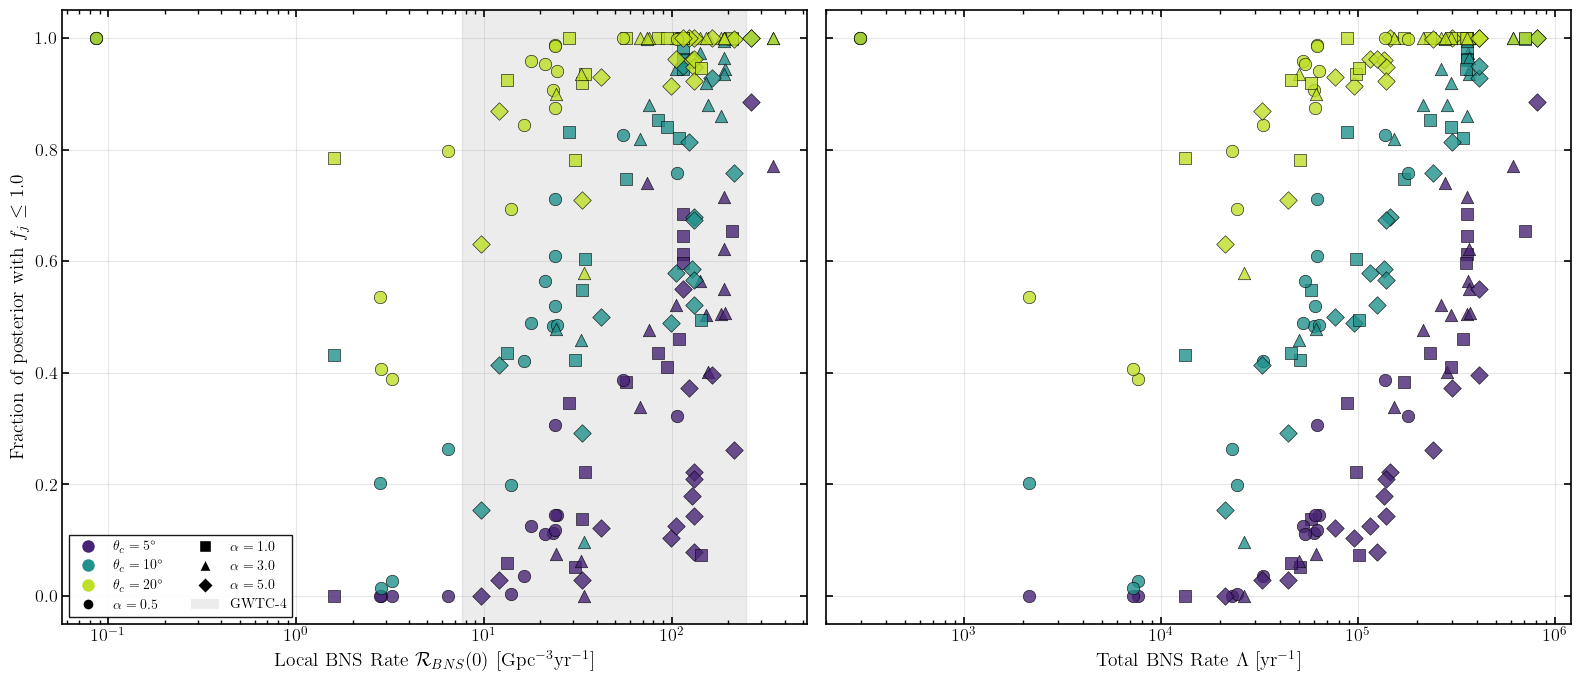

Saved plot to Output_files/ProductionPop_Epsilon_10k/theta_boundary_vs_rate.pdf


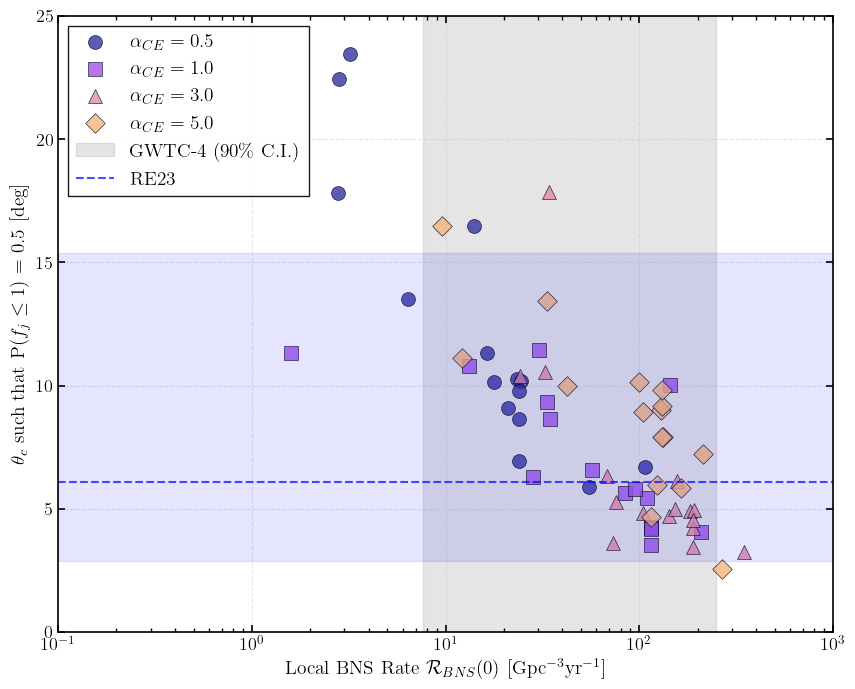

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Local BNS Rate $\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='$\\theta_{c}$ such that P($f_j \\leq 1$) = 0.5 [deg]'>)

In [ ]:
# Generate epsilon-specific plots
#plotter_epsilon.plot_violins_epsilon(filename="epsilon_violin_plot.pdf")
#plotter_epsilon.plot_violins_fj(theta_c_values=[5, 10, 20], filename="fj_violin_plot.pdf")
#plotter_epsilon.plot_fj_vs_rate(theta_c_values=[5, 10, 20], max_fj = 10)
plotter_epsilon.plot_fj_fraction_vs_rate(theta_c_values=[5, 10, 20])
plotter_epsilon.plot_physical_theta_boundary_vs_rate()

In [ ]:
# For Flat Theta models (6 parameters)
run_name = "ProductionPop_Flat_10k_new_new"
BASE_DIR_FLAT   = Path(run_name)  # Make sure this is the flat theta directory
OUTPUT_DIR_FLAT = Path("Output_files") / run_name
OUTPUT_DIR_FLAT.mkdir(parents=True, exist_ok=True)

# For Flat Theta models (6 parameters)
plotter_fj = FjModelPlotter(
    samp_names  =   SAMP_NAMES,
    base_dir    =   str(BASE_DIR_FLAT),
    data_files_dir  =str(DATA_FILES_DIR),
    output_dir  =   str(OUTPUT_DIR_FLAT),
    discard     =   1000,
    thin        =   20,
    k_params    =   6,
    theta_c_idx =   4,          # Index of theta_c in parameter array
    fj_idx      =   5,          # Index of fj in parameter array
)

Loading and processing model data...
Successfully processed 64 models.


Saved plot to Output_files/ProductionPop_Flat_10k_new_new/theta_boundary_vs_rate.pdf


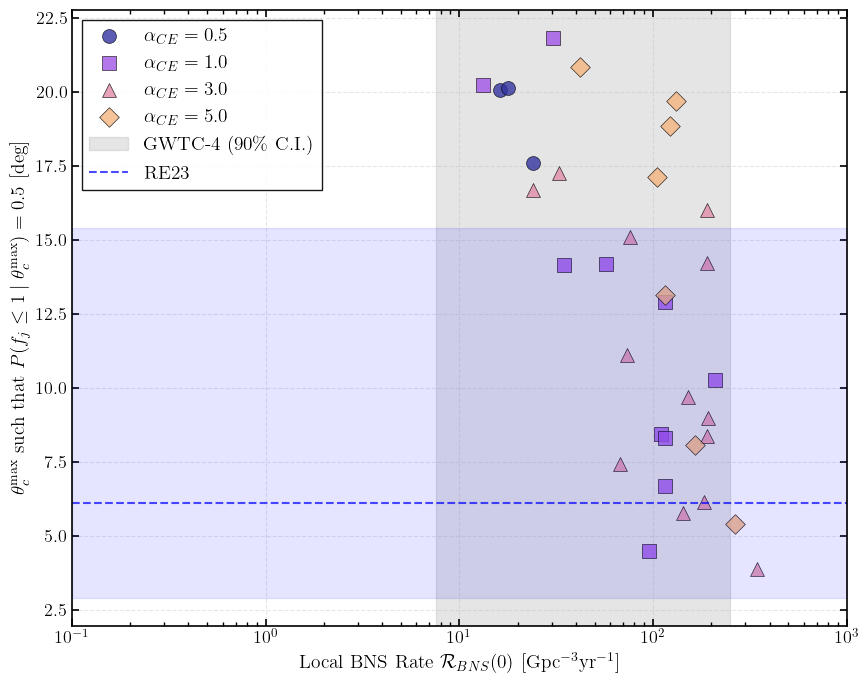

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Local BNS Rate $\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='$\\theta_{c}^{\\max}$ such that $P(f_j \\leq 1 \\mid \\theta_{c}^{\\max}) = 0.5$ [deg]'>)

In [ ]:
plotter_fj.plot_physical_theta_boundary_vs_rate()

In [ ]:
# Generate fj-specific plots
#plotter_fj.plot_violins_fj(filename="fj_violin_plot.pdf")
#plotter_fj.plot_fj_fraction_vs_rate()
#plotter_fj.plot_fj_posteriors(filename="fj_posteriors.pdf")
#plotter_fj.plot_theta_c_posteriors(filename="theta_c_posteriors.pdf")

In [ ]:
%load_ext autoreload
%autoreload 2

from src.plots_oop_epsilon import LogNormalModelPlotter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# For Log-Normal Theta models (6 parameters)
run_name = "ProductionPop_LogNorm_10k_new_new"
BASE_DIR_LN = Path(run_name)
OUTPUT_DIR_LN = Path("Output_files") / run_name
OUTPUT_DIR_LN.mkdir(parents=True, exist_ok=True)

plotter_ln = LogNormalModelPlotter(
    samp_names=SAMP_NAMES,
    base_dir=str(BASE_DIR_LN),
    data_files_dir=str(DATA_FILES_DIR),
    output_dir=str(OUTPUT_DIR_LN),
    discard=300,
    thin=20,
    k_params=6,
    theta_c_idx=4,  # Index of log10(theta_c_median)
    fj_idx=5,
)

Loading and processing model data...
Successfully processed 64 models.


Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/theta_boundary_vs_rate.pdf


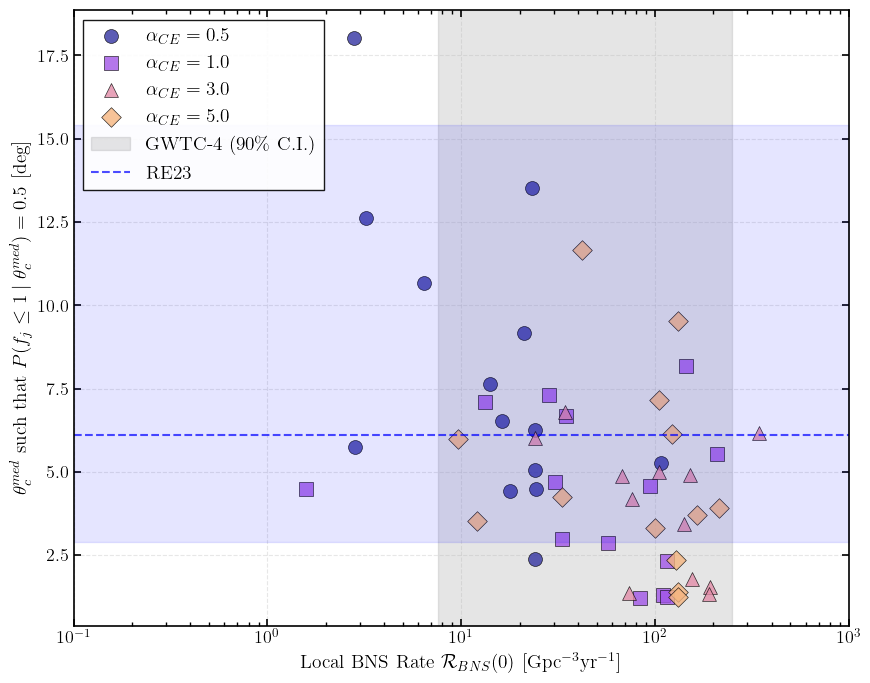

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Local BNS Rate $\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='$\\theta_{c}^{med}$ such that $P(f_j \\leq 1 \\mid \\theta_{c}^{med}) = 0.5$ [deg]'>)

In [ ]:
plotter_ln.plot_physical_theta_boundary_vs_rate()

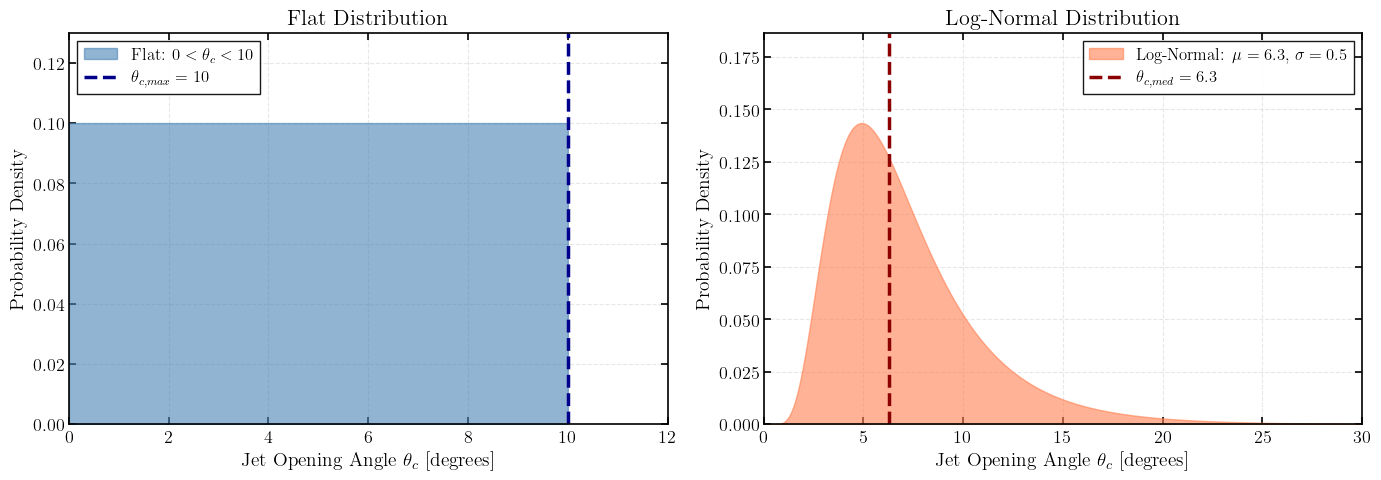

In [ ]:
# Add this cell to your notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

def plot_jet_angle_distributions(theta_c_max=10, theta_c_med=6.3, sigma_theta=0.5, figsize=(14, 5)):
    """
    Plot flat and log-normal jet angle distributions side by side.
    
    Parameters:
    -----------
    theta_c_max : float
        Maximum jet opening angle for flat distribution (degrees)
    theta_c_med : float
        Median jet opening angle for log-normal distribution (degrees)
    sigma_theta : float
        Standard deviation parameter for log-normal distribution
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # ========== LEFT PANEL: Flat Distribution ==========
    theta_flat = np.linspace(0, theta_c_max, 1000)
    pdf_flat = np.ones_like(theta_flat) / theta_c_max  # Uniform distribution
    
    ax1.fill_between(theta_flat, 0, pdf_flat, alpha=0.6, color='steelblue', 
                     label=f'Flat: $0° < \\theta_c < {theta_c_max}°$')
    ax1.axvline(theta_c_max, color='darkblue', linestyle='--', linewidth=2.5, 
                label=f'$\\theta_{{c,max}} = {theta_c_max}°$')
    
    ax1.set_xlabel('Jet Opening Angle $\\theta_c$ [degrees]', fontsize=14)
    ax1.set_ylabel('Probability Density', fontsize=14)
    ax1.set_title('Flat Distribution', fontsize=16, weight='bold')
    ax1.set_xlim(0, theta_c_max * 1.2)
    ax1.set_ylim(0, max(pdf_flat) * 1.3)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # ========== RIGHT PANEL: Log-Normal Distribution ==========
    # Log-normal parameters: if median is theta_c_med, then mu = log(theta_c_med)
    mu = np.log(theta_c_med)
    theta_ln = np.linspace(0.1, theta_c_max * 3, 1000)
    
    # SciPy's lognorm uses: scale=exp(mu), s=sigma
    pdf_ln = lognorm.pdf(theta_ln, s=sigma_theta, scale=np.exp(mu))
    
    ax2.fill_between(theta_ln, 0, pdf_ln, alpha=0.6, color='coral', 
                     label=f'Log-Normal: $\\mu = {theta_c_med:.1f}°$, $\\sigma = {sigma_theta}$')
    ax2.axvline(theta_c_med, color='darkred', linestyle='--', linewidth=2.5, 
                label=f'$\\theta_{{c,med}} = {theta_c_med:.1f}°$')
    
    ax2.set_xlabel('Jet Opening Angle $\\theta_c$ [degrees]', fontsize=14)
    ax2.set_ylabel('Probability Density', fontsize=14)
    ax2.set_title('Log-Normal Distribution', fontsize=16, weight='bold')
    ax2.set_xlim(0, theta_c_max * 3)
    ax2.legend(fontsize=12, loc='upper right')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_ylim(0, max(pdf_ln) * 1.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)

# Example usage:
fig, axes = plot_jet_angle_distributions(theta_c_max=10, theta_c_med=6.3, sigma_theta=0.5)

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/fj_violin_plot.pdf


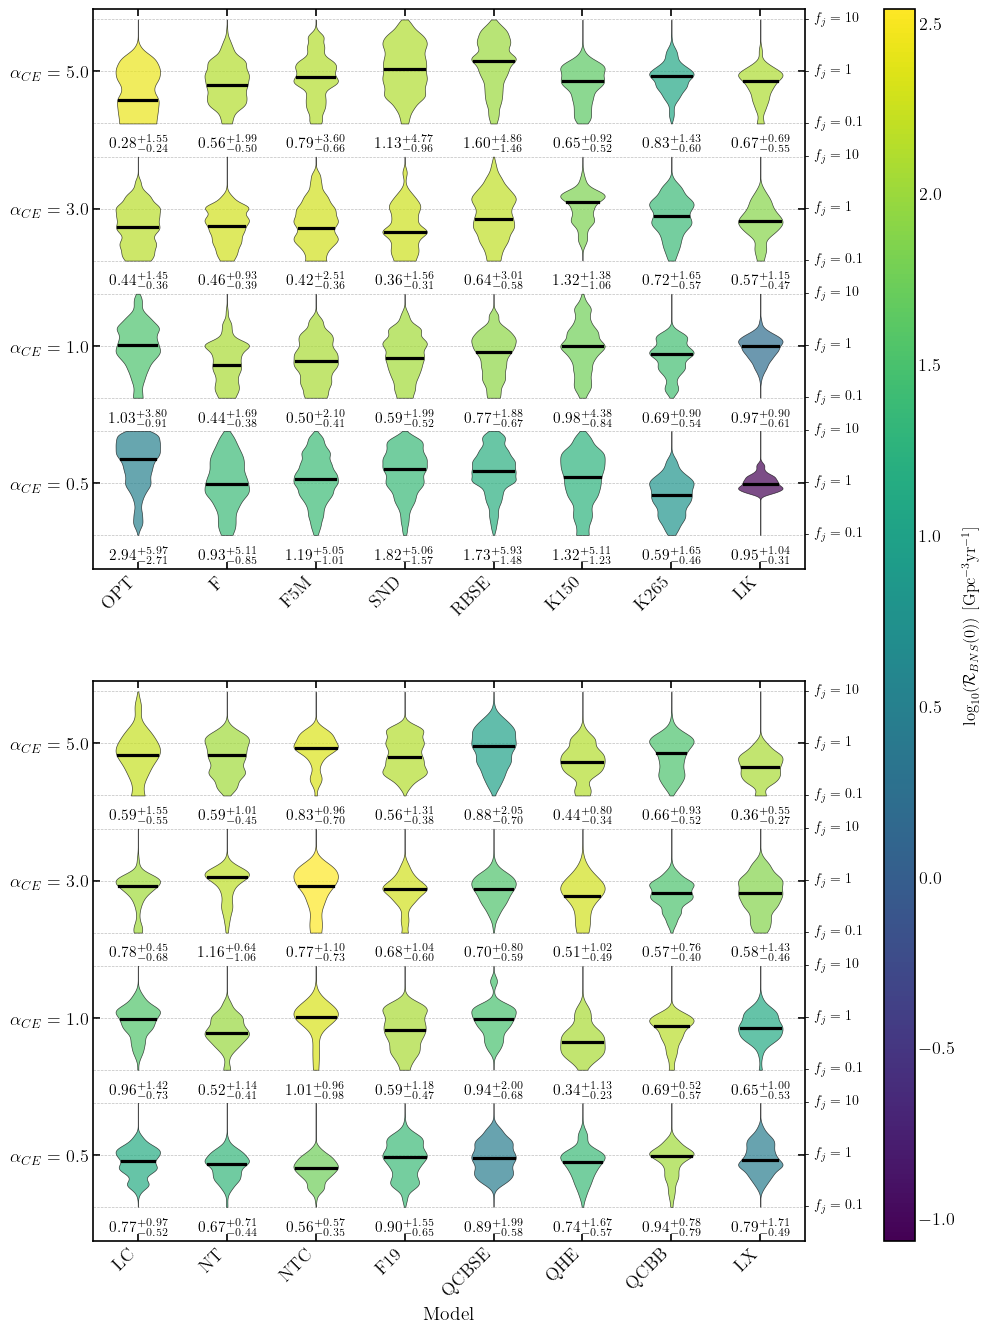

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/fj_fraction_vs_rate.pdf


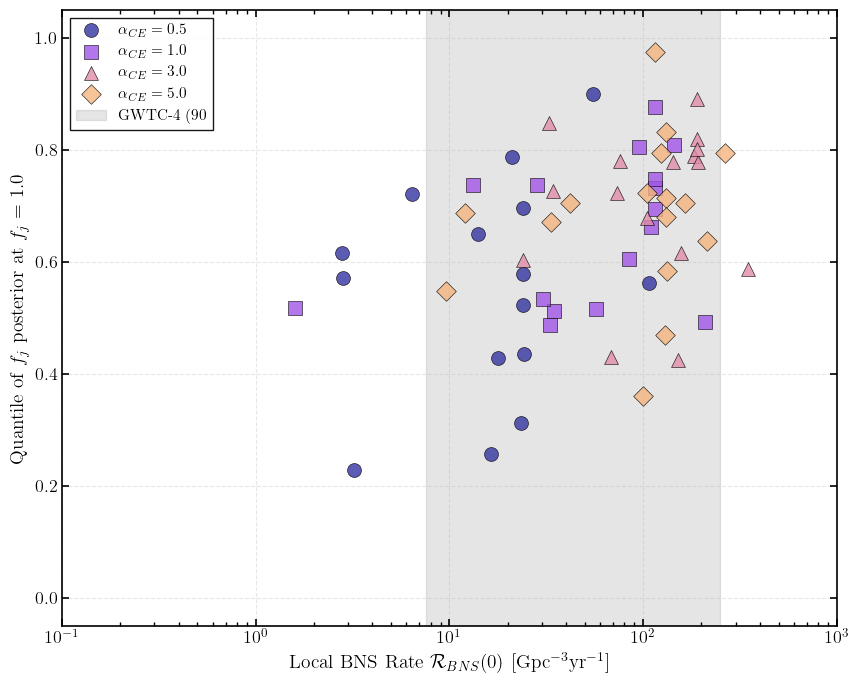

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/theta_c_vs_fj_scatter.pdf


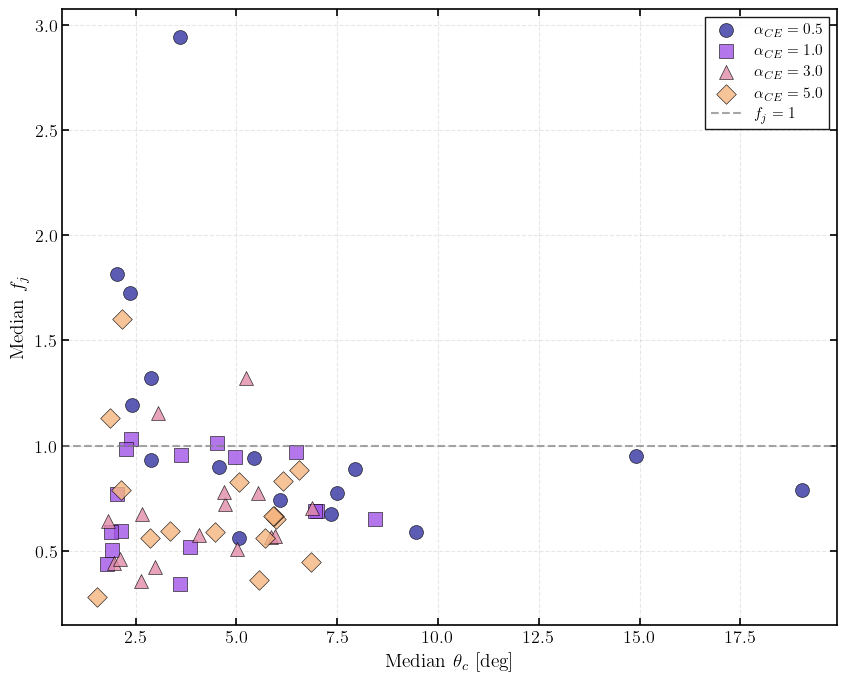

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Median $\\theta_c$ [deg]', ylabel='Median $f_j$'>)

In [ ]:
# Generate plots
plotter_ln.plot_violins_fj(filename="fj_violin_plot.pdf", max_fj=10)
plotter_ln.plot_fj_fraction_vs_rate()
plotter_ln.plot_theta_c_vs_fj(show_errorbars=False)

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/theta_c_times_fj_vs_rate.pdf


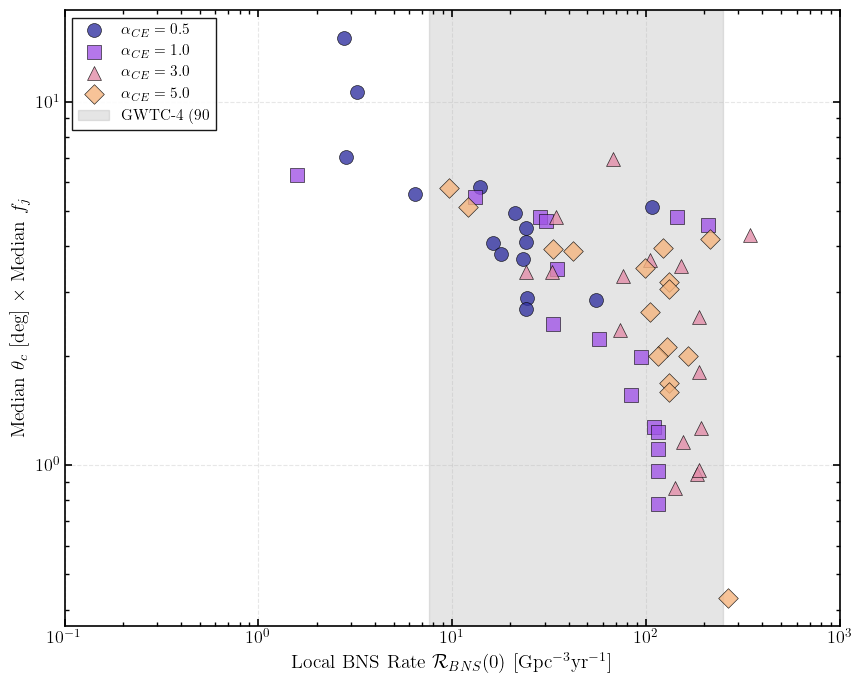

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/sgrb_rate_vs_local_rate_lognormal.pdf


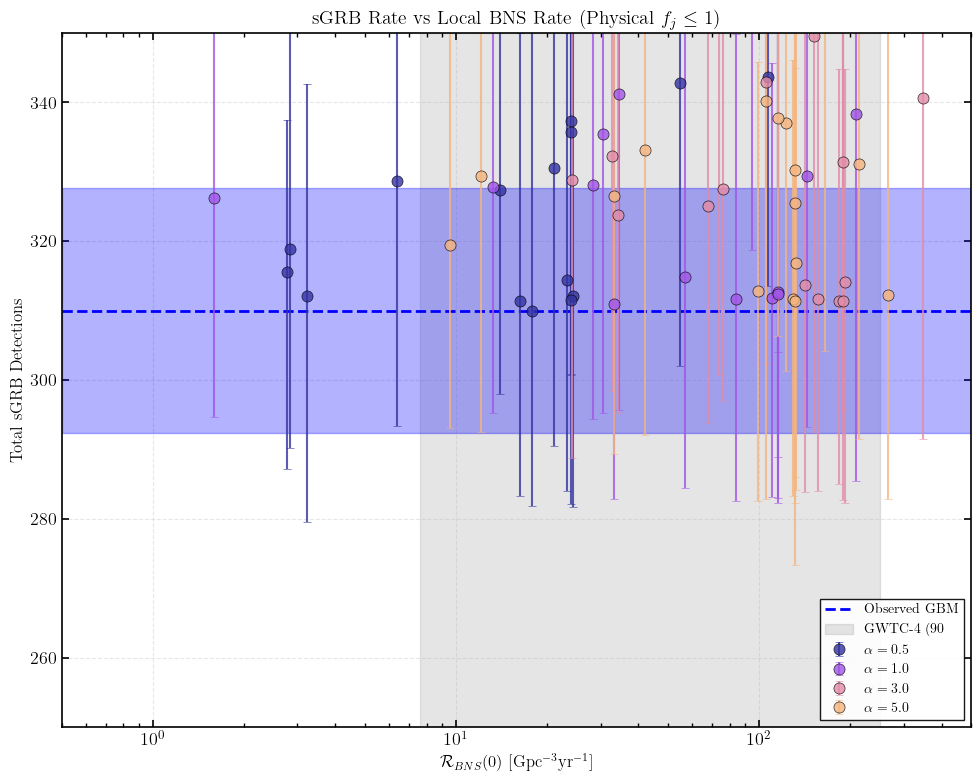

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'sGRB Rate vs Local BNS Rate (Physical $f_j \\leq 1$)'}, xlabel='$\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='Total sGRB Detections'>)

In [ ]:
plotter_ln.plot_theta_c_times_fj_vs_rate()
plotter_ln.plot_sgrb_rate_vs_local_rate(geom = geom_eff_interp)

In [ ]:
1/0

ZeroDivisionError: division by zero

In [ ]:
# Generate the plots
#print("\n--- Generating f_j vs. Rate Plot ---")
#plotter.plot_fj_vs_rate()

#print("\n--- Generating Model Probability Grid Plot ---")

#print("\n--- Generating AIC vs. Epsilon Plot ---")
#plotter.plot_aic_vs_epsilon() 

#print("\n--- Generating f_j Violin Plot ---")
#plotter.plot_violins(plot_type="fj", filename="fj_violin_plot.pdf")

#print("\n--- Generating Epsilon Violin Plot ---")
#plotter.plot_violins(plot_type="epsilon", filename="epsilon_violin_plot.pdf")


#plotter.plot_probability_grid_epsilon(filename="probability_grid_epsilon.pdf")

#plotter.plot_combined_mrd_rates_theta_c(
#    theta_c_values=[5.0, 10.0, 20.0],
#    datafiles_path=Path("datafiles"),
#    filename="combined_mrd_rates_theta_c.pdf"
#)

#epsilon_fj_table = plotter.create_epsilon_fj_table(
#    theta_c_values=[3.4]#[5, 10, 20]
#)

#plotter.print_and_plot_top_models(top_n=5, theta_c_values=[3.4, 5.0])
#plotter.plot_probability_grid()
#plotter.plot_combined_mrd_rates_theta_c()

plotter.plot_probability_vs_r0(filename="probability_vs_r0_flat_theta_c.pdf")

NameError: name 'plotter' is not defined

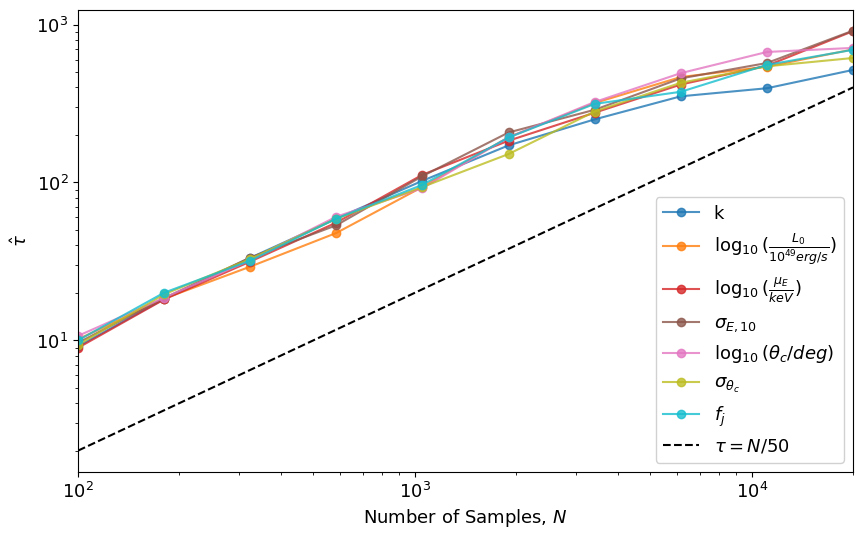

In [ ]:
from src import plots_oop
plotter = plots_oop.MCMCPlotter(
        samplers    =   [backend],
        names       =   ['Fiducial Model'],
        output_dir  =   output_dir,
        burn_in     =   300, # Discard the first 1000 steps
        thin        =   15,
        labels     =   labels,
)

plotter.plot_autocorrelation_times()

Here you can see if there are any strange features in the likelihood terms, usually it quickly (or if you are lucky immediately) converges and oscillates according to the posteriors. 

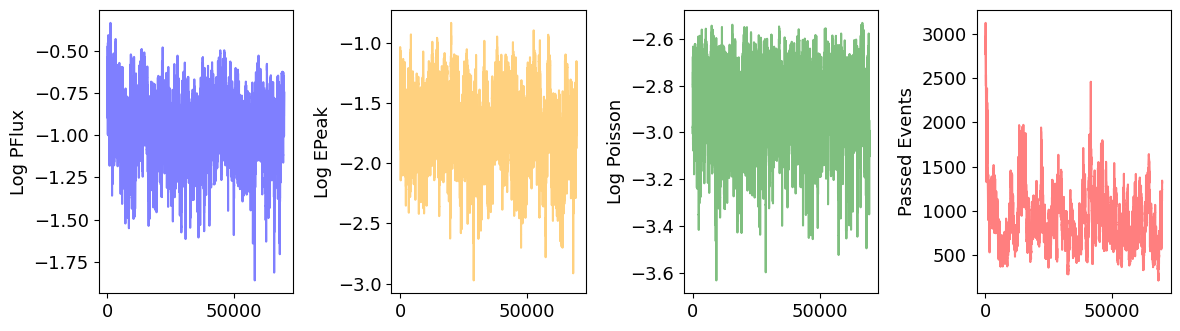

In [ ]:
# plot the blobs 

blobs = backend.get_blobs(discard=300, flat=True)
l_pflux = blobs["l_pflux"]
l_epeak = blobs["l_epeak"]
l_poiss = blobs["l_poiss"]
effciency = blobs["l_eff"]

def running_avg(arr, window_size=300):
    """Calculate the running average of an array."""
    return np.convolve(arr, np.ones(window_size)/window_size, mode='valid')

l_pflux, l_epeak, l_poiss, effciency = [
    running_avg(arr) for arr in [l_pflux, l_epeak, l_poiss, effciency]
]

steps = np.arange(len(l_pflux)) / n_walkers  # Divide by nwalkers to get the step number

fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))
axs[0].plot(steps, l_pflux, label='Log PFlux', color='blue', alpha=0.5)
axs[0].set_ylabel('Log PFlux')
axs[1].plot(steps, l_epeak, label='Log EPeak', color='orange', alpha=0.5)
axs[1].set_ylabel('Log EPeak')
axs[2].plot(steps, l_poiss, label='Log Poisson', color='green', alpha=0.5)
axs[2].set_ylabel('Log Poisson')
axs[3].plot(steps, effciency * 25e3, color='red', alpha=0.5)
axs[3].set_ylabel('Passed Events')

plt.tight_layout()
plt.savefig(output_dir / "blobs_evolution.png")
plt.show()  

The following prepares the emprical cdfs.

In [ ]:
# take the last 100 samples
flat_samples = sampler.get_chain(discard=300, thin=20, flat=True)
last_samples = flat_samples[-200:]

# extract the parameters
p_flx   = []
e_pk    = []
rates   = []
for i, theta in enumerate(last_samples) :
    epsilon         = theta[-1]
    gbm_eff         = 0.6 # this is the efficiency of the GBM detector
    grbs_per_year   = epsilon * len(default_params.z_arr) * gbm_eff # Number of GRBs per year in the whole universe

    #poiss ncertaintey
    n_events    = 10_000 #default_params.rng.poisson(grbs_per_year * YEARS * geo_factor * gbm_eff)
    results     = simplified_montecarlo(theta, n_events)

    # Calculate the log likelihood
    p_flux_sim  = results["p_flux"] # erg to keV to as to have adimensional ph / cm2 / s
    z_arr_sim   = results["z_arr"]
    E_p_obs_sim = results["E_p_obs"] 

    mask = (
        (p_flux_sim > 4) & 
        (E_p_obs_sim > 50) & 
        (E_p_obs_sim < 10_000)
    )

    p_flux_sim  = p_flux_sim[mask]
    E_p_obs_sim = E_p_obs_sim[mask]

    p_flx.append(p_flux_sim)
    e_pk.append(E_p_obs_sim)

    number_of_years_simulated = n_events / (grbs_per_year)  # Number of years we simulated

    observed_rate   = sum(p_flux_sim > 4) / number_of_years_simulated  # Measured rate of events per year per simulation

    rates.append(observed_rate)
    
def empirical_cdf(data):
    """Compute the empirical cumulative distribution function (CDF) of the data."""
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Plot the empirical CDF of the simulated data vs real data
p_flx   = np.concatenate(p_flx)
e_pk    = np.concatenate(e_pk)

p_flx_emp, cdf_p_flx    = empirical_cdf(p_flx)
e_pk_emp, cdf_e_pk      = empirical_cdf(e_pk)

p_flx_emp_data, cdf_p_flx_data  = empirical_cdf(default_params.pflux_data)
e_pk_emp_data, cdf_e_pk_data    = empirical_cdf(default_params.epeak_data)

Compare the actual CDFs of the simulated data with the ones from the real data.

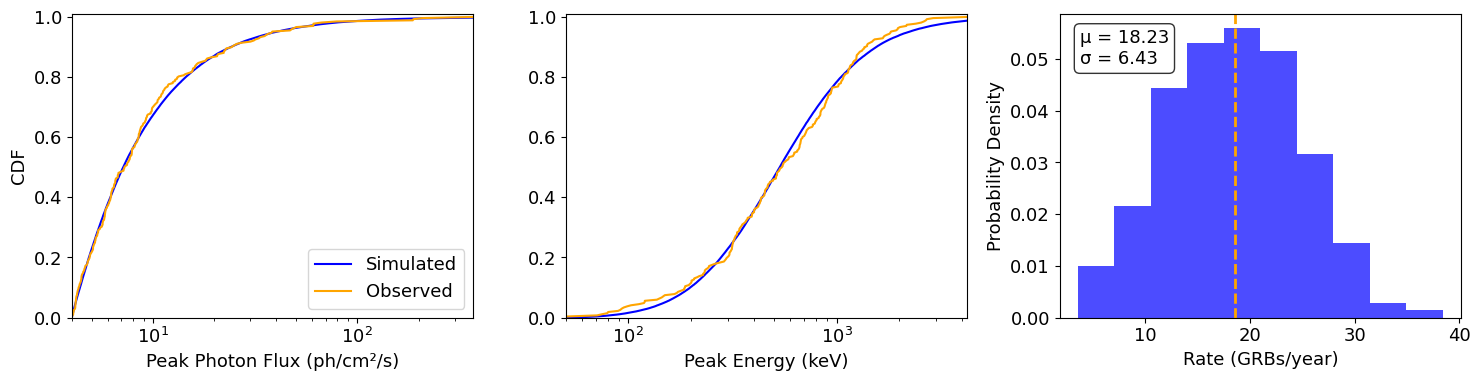

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# First plot: Peak Photon Flux CDF
axs[0].plot(p_flx_emp, cdf_p_flx, label='Simulated', color='blue')
axs[0].plot(p_flx_emp_data, cdf_p_flx_data, label='Observed', color='orange')
axs[0].set_xlabel(r"Peak Photon Flux (ph/cm²/s)")
axs[0].set_ylabel('CDF')
axs[0].legend()
axs[0].set_xscale('log')
axs[0].set_xlim(4, max(default_params.pflux_data))
axs[0].set_ylim(0, 1.01)

# Second plot: Peak Energy CDF
axs[1].plot(e_pk_emp, cdf_e_pk, label='Simulated', color='blue')
axs[1].plot(e_pk_emp_data, cdf_e_pk_data, label='Observed', color='orange')
axs[1].set_xlabel(r'Peak Energy (keV)')
axs[1].set_xscale('log')
axs[1].set_xlim(50, max(default_params.epeak_data))
axs[1].set_ylim(0, 1.01)

# Third plot: Rate comparison (Poisson process)
axs[2].hist(rates, bins=10, alpha=0.7, label='Simulated Rates', color='blue', density=True)
axs[2].axvline(default_params.yearly_rate, color='orange', linestyle='--', linewidth=2, 
               label=f'Expected Rate\n({default_params.yearly_rate:.2f} GRBs/year)')
axs[2].set_xlabel('Rate (GRBs/year)')
axs[2].set_ylabel('Probability Density')
axs[2].text(0.05, 0.95, f'μ = {np.mean(rates):.2f}\nσ = {np.std(rates):.2f}', 
            transform=axs[2].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(output_dir / "combined_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Multiple populations

# Old

In [ ]:
# --- OPTION 2: Plot Epsilon Results ---
run_name        = "ProductionPop_25_deg_linear_luminosity"
BASE_DIR        = Path(run_name)
OUTPUT_DIR      = Path("Output_files") / run_name
k_params        = 5

DATA_FILES_DIR  = datafiles
SAMP_NAMES      = samp_names

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
# For Epsilon models (5 parameters)
plotter_epsilon = EpsilonModelPlotter(
    samp_names=SAMP_NAMES,
    base_dir=str(BASE_DIR),
    data_files_dir=str(DATA_FILES_DIR),
    output_dir  =str(OUTPUT_DIR),
    discard     =   300,
    thin        =   15,
    k_params=5,
)

Loading and processing model data...
Successfully processed 64 models.


Saved plot to Output_files/ProductionPop_25_deg_linear_luminosity/sgrb_rate_vs_local_rate_epsilon.pdf


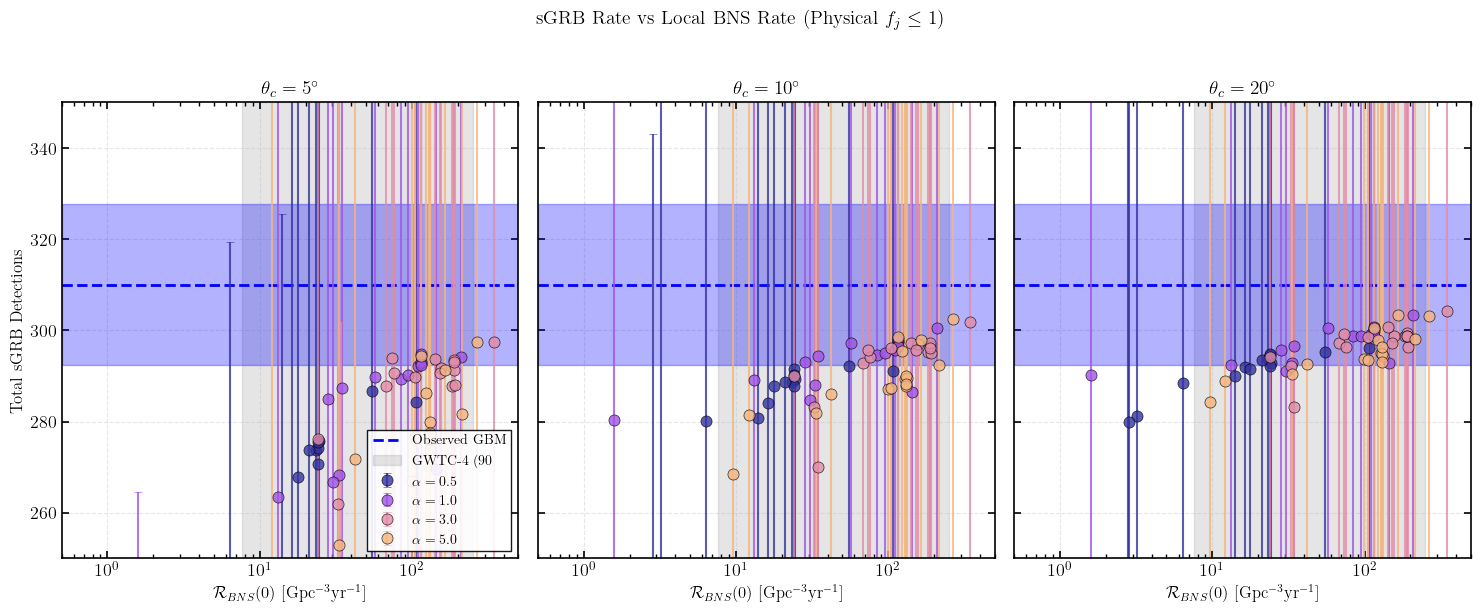

(<Figure size 1500x600 with 3 Axes>,
 array([<Axes: title={'center': '$\\theta_c = 5^\\circ$'}, xlabel='$\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='Total sGRB Detections'>,
        <Axes: title={'center': '$\\theta_c = 10^\\circ$'}, xlabel='$\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]'>,
        <Axes: title={'center': '$\\theta_c = 20^\\circ$'}, xlabel='$\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]'>],
       dtype=object))

In [ ]:

plotter_epsilon.plot_sgrb_rate_vs_local_rate(theta_c_values = [5, 10, 20])